In [1]:
import gym
from gym.envs.classic_control import CartPoleEnv
import numpy as np
import matplotlib.pyplot as plt
import inspect

In [2]:
base_env = gym.make("CartPole-v1")
# dir(base_env)
# base_env.__dict__
# help(base_env)
# print(super().base_env)

In [8]:
class CartPoleWrapper(gym.envs.classic_control.cartpole.CartPoleEnv):
    """
    This wrapper adds:
      - 'reached_goal' property, where goal is to keep the cartpole upright for 200 steps.
      - 'reset' functionality to be able to set the start state
    """

    def __init__(self, env):
        super().__init__()
        # self._max_steps = env.spec.max_episode_steps
        self.discount = 0.7
        self.pos_size = 100
        self.ang_size = 100

    def reset(self, init_state):

        super().reset()  # call the base reset to do all of the other stuff
        self.state = np.array(init_state)  # and then edit state if we want
        return self.state

    def get2Dstate(self, curr_state, prev2Dstate=None):
        # curr_state numpy array [xpos, xvel, angle, angvel] # even though it says state[3] = tip_vel in the docs, its actually vel
        # max values are:         [+-4.8, inf, +-12 = +-0.21rad, inf]
        pos_edges, ang_edges = np.linspace(-4.8, 4.8, self.pos_size + 1), np.linspace(-12 * np.pi / 180, 12 * np.pi / 180, self.ang_size + 1)
        new_pos, _, _ = np.histogram2d([curr_state[2], ], [curr_state[0], ], bins=(ang_edges, pos_edges))
        prev_pos, _, _ = np.histogram2d([curr_state[2] - curr_state[3], ], [curr_state[0] - curr_state[1], ],
                                        bins=(ang_edges, pos_edges))
        if prev2Dstate is None:
            return new_pos + self.discount * prev_pos
        else:
            return new_pos + self.discount * prev2Dstate

    def get1Dstate(self, state_2D):
        traj1D = np.reshape(state_2D, (-1,))    # converts to (10000,) array
        # s_ten = torch.tensor(traj1D, dtype=torch.float)
        return tuple(traj1D.tolist())

    def getActionSize(self):    # only works for discrete actions need to update!
        x = 0
        while self.action_space.contains(x):
            x += 1
        return x

    def get2DstateSize(self):
        return self.pos_size, self.ang_size

    def printState(self, state_2D):
        plt.imshow(state_2D, extent=[-4.8, 4.8, -12*np.pi/180, 12*np.pi/180], cmap='jet', aspect='auto')
        plt.xlabel("X-Position")
        plt.ylabel("Angular Position")
        plt.colorbar()
        plt.show()

    # @property
    # def reached_goal(self):
    #     return self._steps >= self._max_steps

In [9]:
env = CartPoleWrapper(gym.make("CartPole-v1"))   

In [6]:
# curr_state numpy array [xpos, xvel, angle, angvel]
s_obs = [0.1, 0.1, 0.1, 0.1]
print(env.reset(s_obs))
tobs, re, d, inf = env.step(0)
print(tobs)
tobs, re, d, inf = env.step(0)
print(tobs)

[0.1 0.1 0.1 0.1]
[ 0.102      -0.09640235  0.102       0.42248276]
[ 0.10007195 -0.29281027  0.11044966  0.74549943]


[0.1 0.1 0.1 0.1]


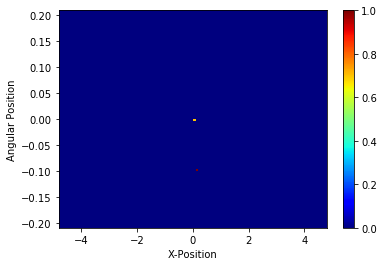

[ 0.102      -0.09640235  0.102       0.42248276]


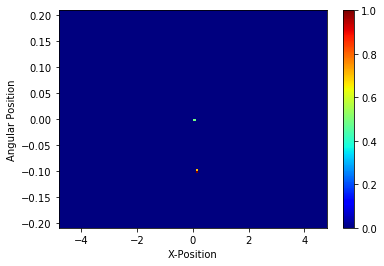

[ 0.10007195 -0.29281027  0.11044966  0.74549943]


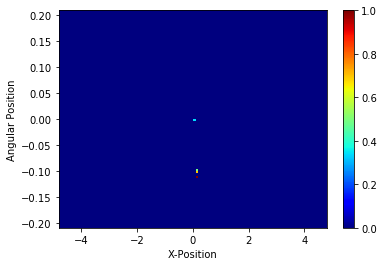

[ 0.09421575 -0.48926897  0.12535964  1.07079805]


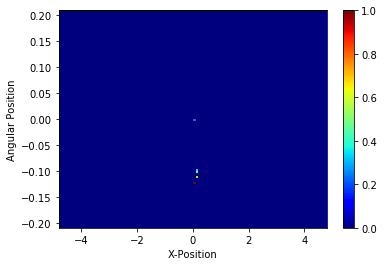

[ 0.08443037 -0.68580531  0.1467756   1.40004843]


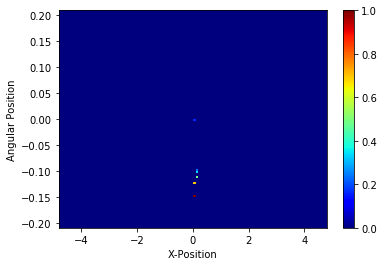

[ 0.07071426 -0.88241475  0.17477657  1.73478888]


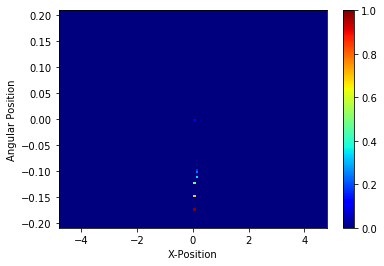

[ 0.05306597 -1.07904693  0.20947235  2.07636684]


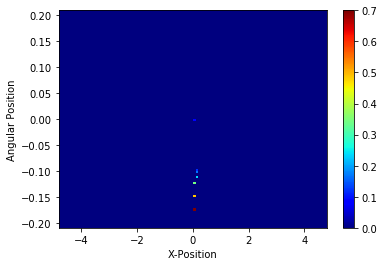

In [7]:
start_obs = env.reset(s_obs)
total_reward = 0.0
state2D = env.get2Dstate(start_obs)
print(start_obs)
env.printState(state2D)

while True:
    
    obs, reward, done, _ = env.step(0)
    print(obs)
    state2D = env.get2Dstate(obs, state2D)
    # env.render()
    env.printState(state2D)

    if done:
        break